<center>
    <h1>EM Connectomics - Question 3</h1>
    <h2>Summer Workshop on the Dynamic Brain</h2>
    <h3>Wednesday, August 25, 2021</h3>
</center>

**Task 3:** Do the targets of a pyramidal cell differ as you get farther away from the soma?

Various studies have found that cortical excitatory neurons exhibit targeting preferences that change with distance along the axon. For example, in medial entorhinal cortex, [Schmidt et al.](https://pubmed.ncbi.nlm.nih.gov/28959971/) found that, closer to the soma, there was a bias toward targeting inhibitory neurons. We're going to look at this question from our EM dataset. This question will extend the E/I target analysis from Task 2 and add in spatial information about the synapse locations.

**Task 3.0:** Import the key modules and initialize a client

In [1]:
# Import modules
from meshparty import meshwork, trimesh_vtk
from caveclient import CAVEclient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize a client for the "minnie65_public_v117" datastack.
datastack = 'minnie65_public_v117'
client = CAVEclient(datastack)

**Task 3.1:** Find where the output synapses are on our neuron relative to the soma in both physical space and as a path along the arbor.

For this step, for each axonal presynaptic site synapse compute the distance to the soma as both a euclidean value and a distance along the axon. As a check at the end, visualize the distribution of the two distances. For this example, use `root_id = 864691134884807418`, which is a proofread L2/3 pyramidal cell in one of the HVAs. If you have time, feel free to look at the same analysis with other neurons.

In [2]:
# Load the h5 file for the root id specified
root_id = 864691134884807418

# Get the filename for this root id on your computer
filename = f"{root_id}_axon_labeled.h5"

nrn = meshwork.load_meshwork(filename)

In [3]:
# Extract synapse info into a dataframe
presyn_df = nrn.anno.pre_syn.df[['ctr_pt_position', 'post_pt_root_id', 'pre_pt_mesh_ind', 'size']]

# Extra-ideal answer: use a filter query to specify only synapses on the axon
presyn_df = nrn.anno.pre_syn.filter_query(nrn.anno.is_axon.mesh_mask).df[['ctr_pt_position', 'post_pt_root_id', 'pre_pt_mesh_ind', 'size']]

In [4]:
# Get euclidean distance for each synapse
voxel_resolution = np.array([4,4,40])
soma_position = nrn.vertices[nrn.root]
synapse_position = np.vstack(presyn_df['ctr_pt_position']) * voxel_resolution

syn_dist_euclidean = np.linalg.norm(synapse_position-soma_position, axis=1)/1000
presyn_df['d_euclid'] = syn_dist_euclidean

In [5]:
# Get on-arbor distance for each synapse
syn_dist_arbor = nrn.distance_to_root(presyn_df['pre_pt_mesh_ind'])/1000

In [6]:
presyn_df['d_arbor'] = syn_dist_arbor

In [7]:
presyn_df['d_arbor'].describe()

count     553.000000
mean      378.152062
std       158.777735
min        99.605184
25%       274.966834
50%       350.225932
75%       435.685015
max      1033.314306
Name: d_arbor, dtype: float64

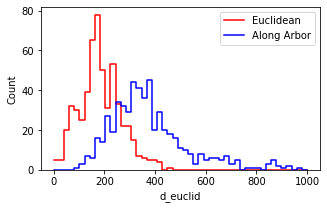

In [8]:
# Visualize the two distances as a histogram
# For bins, use 50 micron bins up to a distance of 1000 microns.
fig, ax = plt.subplots(figsize=(5,3))
bins = np.linspace(0, 1000, 50)

sns.histplot(x='d_euclid', data=presyn_df, bins=bins, color='r', element='step', fill=False)
sns.histplot(x='d_arbor', data=presyn_df, bins=bins, color='b', element='step', fill=False)
ax.legend(['Euclidean', 'Along Arbor'])


**Task 3.2:** Compute what cell type (if known) does each synapse target.

For this step, for each axonal presynaptic site synapse compute the target cell type if it is a single soma, or else label it 'unclassified'.

In [9]:
# Get the soma table and compute single soma root ids

soma_table = client.info.get_datastack_info()['soma_table']
soma_df = client.materialize.query_table(soma_table)

nrn_soma_df = soma_df.query('cell_type == "neuron"').reset_index(drop=True)
nrn_soma_df['num_soma'] = nrn_soma_df.groupby('pt_root_id').transform('count')['valid']

nrn_single_soma_df = nrn_soma_df.query('num_soma==1').reset_index(drop=True)

In [10]:
# Find which targets of our cell are onto single-soma neurons.

single_soma_ids = nrn_single_soma_df['pt_root_id'].values

presyn_df.loc[presyn_df.query('post_pt_root_id in @single_soma_ids').index, 'is_single'] = True
presyn_df['is_single'].fillna(False, inplace=True)

ss_targets = np.unique(presyn_df.query('is_single')['post_pt_root_id'].values)

In [11]:
# Get the cell type of those single soma targets and add them as a labeled column

ei_model_table = 'allen_soma_ei_class_model_v1'
ei_df = client.materialize.query_table(ei_model_table)

presyn_df = presyn_df.merge(ei_df.query('pt_root_id in @ss_targets')[['pt_root_id', 'cell_type']],
                how='left', left_on='post_pt_root_id', right_on='pt_root_id').drop(columns='pt_root_id')

presyn_df['cell_type'].fillna('unclassified', inplace=True)

**Task 3.3:** Measure how the target cell type change with distance.

Here, look at the distribution of target preference as a function of distance from soma. First, make histograms of targeting by cell type and distance from soma using both distances. How do they differ? Next, bin the data by distance and compute the fraction of targets that are excitatory, and plot this value as a function of distance. For bins, use a 50 micron bin width.

Text(0.5, 1.0, 'Along arbor')

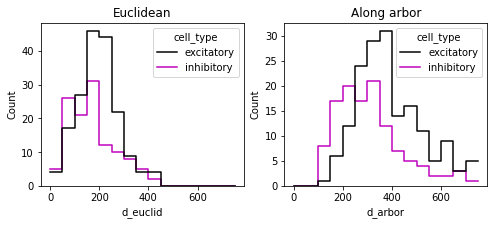

In [12]:
# Visualize the two distances as a histogram
fig, axes = plt.subplots(figsize=(8, 3), ncols=2)
bins = np.arange(0, 800, 50)

ax = axes[0]
sns.histplot(
    x='d_euclid',
    hue='cell_type',
    data=presyn_df.query('cell_type != "unclassified"'),
    bins=bins,
    element='step',
    palette={'excitatory': 'k', 'inhibitory': 'm'},
    fill=False,
    ax=ax,
)
ax.set_title('Euclidean')

ax = axes[1]
sns.histplot(
    x='d_arbor',
    hue='cell_type',
    data=presyn_df.query('cell_type != "unclassified"'),
    bins=bins,
    element='step',
    palette={'excitatory': 'k', 'inhibitory': 'm'},
    fill=False,
    ax=ax,
)
ax.set_title('Along arbor')

# By eye, there is a clear left shift of the inhibitory synpases on the "along arbor" version but not really the euclidean

In [13]:
# Now we bin the data:

presyn_df['d_arbor_bin'] = np.digitize(presyn_df['d_arbor'], bins)
presyn_df['d_euclid_bin'] = np.digitize(presyn_df['d_euclid'], bins)

In [14]:
# Find the fraction of synpases that are excitatory for that are excitatory in each bin.
# If you want to get a confidence interval as well, look at the function `proportion_confint` in the statsmodels python package

arbor_bin_df = presyn_df.query('cell_type!="unclassified"').groupby(['d_arbor_bin', 'cell_type']).agg({'size': 'count'}).reset_index()

arbor_bin_pivot_df = arbor_bin_df.pivot_table(index='d_arbor_bin', columns='cell_type', values='size')
arbor_bin_pivot_df['total'] = arbor_bin_pivot_df['excitatory']+arbor_bin_pivot_df['inhibitory']
arbor_bin_pivot_df['e_frac'] = arbor_bin_pivot_df['excitatory'] / arbor_bin_pivot_df['total']

import statsmodels.api as sm
conf_min, conf_max = sm.stats.proportion_confint(arbor_bin_pivot_df['excitatory'], arbor_bin_pivot_df['total'], method='wilson')

arbor_bin_pivot_df['e_frac_min'] = conf_min
arbor_bin_pivot_df['e_frac_max'] = conf_max

In [15]:
arbor_bin_pivot_df

cell_type,excitatory,inhibitory,total,e_frac,e_frac_min,e_frac_max
d_arbor_bin,,,,,,
3,1,8,9,0.111111,0.019891,0.435000
4,6,17,23,0.260870,0.125486,0.464700
5,12,20,32,0.375000,0.229339,0.547456
6,24,17,41,0.585366,0.433671,0.722435
7,29,21,50,0.580000,0.442334,0.706250
8,31,12,43,0.720930,0.573090,0.832534
9,14,7,21,0.666667,0.453735,0.828052
10,16,5,21,0.761905,0.549088,0.893720
11,11,4,15,0.733333,0.480496,0.891025


In [16]:
euclid_bin_df = presyn_df.query('cell_type!="unclassified"').groupby(['d_euclid_bin', 'cell_type']).agg({'size': 'count'}).reset_index()
euclid_bin_pivot_df = euclid_bin_df.pivot_table(index='d_euclid_bin', columns='cell_type', values='size')

euclid_bin_pivot_df['total'] = euclid_bin_pivot_df['excitatory']+euclid_bin_pivot_df['inhibitory']

euclid_bin_pivot_df['e_frac'] = euclid_bin_pivot_df['excitatory'] / euclid_bin_pivot_df['total']

conf_min, conf_max = sm.stats.proportion_confint(euclid_bin_pivot_df['excitatory'], euclid_bin_pivot_df['total'], method='wilson')

euclid_bin_pivot_df['e_frac_min'] = conf_min
euclid_bin_pivot_df['e_frac_max'] = conf_max

In [17]:
euclid_bin_pivot_df

cell_type,excitatory,inhibitory,total,e_frac,e_frac_min,e_frac_max
d_euclid_bin,,,,,,
1,4,5,9,0.444444,0.188779,0.733349
2,17,26,43,0.395349,0.263653,0.544209
3,27,21,48,0.562500,0.422750,0.692987
4,46,31,77,0.597403,0.485769,0.699780
5,44,12,56,0.785714,0.661805,0.872941
6,22,10,32,0.687500,0.514333,0.820475
7,9,8,17,0.529412,0.309632,0.738349
8,4,5,9,0.444444,0.188779,0.733349
9,4,2,6,0.666667,0.299993,0.903229


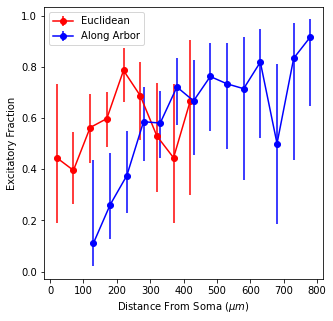

In [18]:
# Visualize fraction of synpases that excitatory as a function of distance bins (with errorbars if you computed confidence intervals)

euclid_y_error = euclid_bin_pivot_df[['e_frac_min', 'e_frac_max']].values.T
euclid_y_error[1,:] = euclid_y_error[1,:]-euclid_bin_pivot_df['e_frac']
euclid_y_error[0,:] = euclid_bin_pivot_df['e_frac']-euclid_y_error[0,:]

arbor_y_error = arbor_bin_pivot_df[['e_frac_min', 'e_frac_max']].values.T
arbor_y_error[1,:] = arbor_y_error[1,:]-arbor_bin_pivot_df['e_frac']
arbor_y_error[0,:] = arbor_bin_pivot_df['e_frac']-arbor_y_error[0,:]

fig, ax = plt.subplots(figsize=(5,5))
ax.errorbar(euclid_bin_pivot_df.index*50-30, euclid_bin_pivot_df['e_frac'], yerr=euclid_y_error, marker='o', color='r')
ax.errorbar(arbor_bin_pivot_df.index*50-20, arbor_bin_pivot_df['e_frac'], yerr=arbor_y_error, marker='o', color='b')
ax.set_ylabel('Excitatory Fraction')
ax.set_xlabel('Distance From Soma ($\mu m$)')

ax.legend(['Euclidean', 'Along Arbor'])

# Sure enough, there's an increase in excitatory targeting as axons get farther from the cell body.